# MIM resonator

Metal – insulator – metal (MIM) waveguides can support surface plasmon resonances at visible wavelengths. They have been widely investigated for applications in image reproduction, photonic integrated circuits, solar cells, metasurfaces, and metalenses. In this notebook we will use [Tidy3D](https://www.flexcompute.com/tidy3d/solver/) to simulate a MIM-based color filter. The original design was proposed in `Xu, T., Wu, YK., Luo, X. et al. "Plasmonic nanoresonators for high-resolution colour filtering and spectral imaging," Nat. Commun. 1, 59 (2010)` [DOI: 10.1038/ncomms1058](https://doi.org/10.1038/ncomms1058).

<img src="img/mim.png" alt="MIM"  width="600"/>

You can find related content in [All-dielectric structural colors](https://www.flexcompute.com/tidy3d/examples/notebooks/AllDielectricStructuralColor/), [Dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/), and [CMOS RGB image sensor](https://www.flexcompute.com/tidy3d/examples/notebooks/CMOSRGBSensor/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it. 

First we will include all the libraries needed to run the notebook.

In [1]:
# Standard python imports.
import numpy as np
import matplotlib.pylab as plt

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

## Simulation Set Up
Fist, we will define the MIM nanoresonator parameters.

In [2]:
# Geometry
period = np.asarray([0.36, 0.27, 0.23])  # Resonator period (um).
duty_cycle = 0.7  # Resonator duty-cycle.
width = period * duty_cycle  # Resonator width (um).
mgf2_t = 0.22  # MgF2 layer thickness (um).
al_t = 0.04  # Al layer thickness (um).
znse_t = 0.1  # ZnSe layer thickness (um).

Material definition.

In [3]:
n_sub = 1.45  # Substrate refractive index.
n_znse = 2.65  # ZnSe refractive index.

mat_sub = td.Medium(permittivity=n_sub**2)  # Substrate material.
mat_znse = td.Medium(permittivity=n_znse**2)  # ZnSe material.
mat_air = td.Medium(permittivity=1)  # Air.
mat_al = td.material_library["Al"]["RakicLorentzDrude1998"]  # Aluminum.
mat_mgf2 = td.material_library["MgF2"]["Horiba"]  # MgF2 material.

Next, we define the wavelength, frequencies, and simulation parameters.

In [4]:
wl_min = 0.400  # Minimum simulation wavelength (um).
wl_max = 0.700  # Maximum simulation wavelength (um).
n_wl = 151  # Number of wavelength points within the bandwidth.
wl_res = np.asarray([0.66, 0.56, 0.49])  # Resonance wavelengths of RGB pixels.
run_time = 1e-12  # Simulation run time (s).

wl_c = (wl_min + wl_max) / 2  # Central simulation wavelength (um).
wl_range = np.linspace(wl_min, wl_max, n_wl)  # Simulation wavelength range (um).
freq_c = td.C_0 / wl_c  # Central simulation frequency (Hz).
freq_range = td.C_0 / wl_range  # Simulation frequency range (Hz).
freq_bw = 0.5 * (freq_range[0] - freq_range[-1])  # Source bandwidth (Hz).
freq_res = td.C_0 / wl_res

size_z = (
    2 * wl_max + mgf2_t + 2 * al_t + znse_t
)  # Simulation size in the z-direction (um).

The MIM nanoresonator simulation is defined within the next function. Here, we show how to set up the MIM structure, define a plane wave source, include a flux monitor to calculate transmittance, and lastly, create a field monitor to record the field distributions at the resonance wavelengths. You can find similar examples in the Tidy3D [examples library](https://www.flexcompute.com/tidy3d/learning-center/example-library/). 

In [5]:
def build_sim(
    p=0.360,
    w=0.150,
):
    _inf = 10

    # Simulation size.
    size_z = 2 * wl_max + 2 * al_t + mgf2_t + znse_t
    size_x = p
    size_y = p

    # Substrate.
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-_inf, -_inf, -_inf), rmax=(_inf, _inf, -size_z / 2 + wl_max)
        ),
        medium=mat_sub,
    )

    # MgF2 layer.
    mgf2_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-_inf, -_inf, -size_z / 2 + wl_max),
            rmax=(_inf, _inf, -size_z / 2 + wl_max + mgf2_t),
        ),
        medium=mat_mgf2,
    )

    # Bottom Al layer.
    al_bot = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-w / 2, -_inf, -size_z / 2 + wl_max + mgf2_t),
            rmax=(w / 2, _inf, -size_z / 2 + wl_max + mgf2_t + al_t),
        ),
        medium=mat_al,
    )

    # ZnSe layer.
    znse_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-w / 2, -_inf, -size_z / 2 + wl_max + mgf2_t + al_t),
            rmax=(w / 2, _inf, -size_z / 2 + wl_max + mgf2_t + al_t + znse_t),
        ),
        medium=mat_znse,
    )

    # Top Al layer.
    al_top = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-w / 2, -_inf, -size_z / 2 + wl_max + mgf2_t + al_t + znse_t),
            rmax=(w / 2, _inf, -size_z / 2 + wl_max + mgf2_t + al_t + znse_t + al_t),
        ),
        medium=mat_al,
    )

    # Plane wave excitation source.
    plane_wave = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq_c, fwidth=freq_bw),
        size=(td.inf, td.inf, 0),
        center=(0, 0, -size_z / 2 + wl_min / 2),
        direction="+",
        pol_angle=0,
        angle_theta=0,
    )

    # Flux monitor to measure the transmittance.
    trans_monitor = td.FluxMonitor(
        center=(0, 0, size_z / 2 - wl_min / 2),
        size=(td.inf, td.inf, 0),
        freqs=freq_range,
        name="T",
    )

    # Field monitor to visualize the fields at the resonator.
    field_xz = td.FieldMonitor(
        center=(0, 0, -size_z / 2 + wl_max + mgf2_t + al_t + znse_t / 2),
        size=(size_x, 0, mgf2_t + al_t + znse_t + al_t),
        freqs=freq_res,
        name="field_xz",
    )

    # Simulation
    sim = td.Simulation(
        size=(size_x, size_y, size_z),
        center=(0, 0, 0),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=40, wavelength=(wl_min + wl_max) / 2
        ),
        structures=[substrate, mgf2_layer, al_bot, znse_layer, al_top],
        sources=[plane_wave],
        monitors=[trans_monitor, field_xz],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),
        symmetry=(-1, 1, 0),
        medium=mat_air,
    )
    return sim

## R, G, and B Color Filter Simulation
Now, we will create a batch object to submit an run all the MIM simulations at once in our servers.

In [6]:
sim = {}
for s in range(len(period)):
    sim[f"MIM_color_filter_{s}"] = build_sim(p=period[s], w=width[s])

Let's look at the simulation setup and verify if everything are on the correct place. We are using symmetry about the *x* and *y* axes to reduce the computation time.

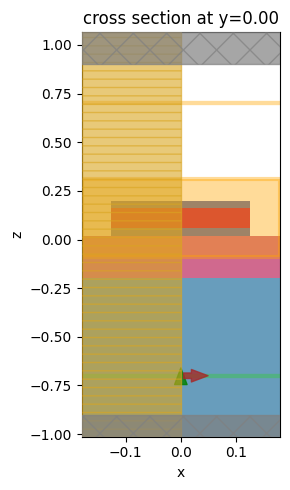

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5), tight_layout=True)
sim["MIM_color_filter_0"].plot(y=0, ax=ax)
ax.set_aspect("auto")
plt.show()

Now, we can run the simulations.

In [8]:
batch_data = web.run_async(simulations=sim, path_dir="data", verbose=False)

## Simulation Results
After running the simulation, we download the results from the server. 

In [9]:
sim_data = []
# Get the results.
for _, sim_res in batch_data.items():
    sim_data.append(sim_res)

And now, we can plot the R, G, B color filter transmittance spectra calculated from the flux monitor. The small differences between the peak transmittance values obtained here and the ones in Figure 1(c) of the reference paper are potentially caused by differences in material properties.

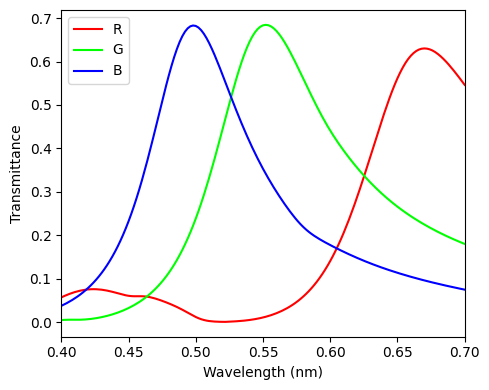

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

ax.plot(wl_range, sim_data[0]["T"].flux, linestyle="solid", color=[1, 0, 0], label="R")
ax.plot(wl_range, sim_data[1]["T"].flux, linestyle="solid", color=[0, 1, 0], label="G")
ax.plot(wl_range, sim_data[2]["T"].flux, linestyle="solid", color=[0, 0, 1], label="B")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmittance")
ax.set_xlim(wl_range[0], wl_range[-1])
ax.legend()

plt.show()

Next, we will look the magnetic field distributions at the R, G, and B resonance wavelengths.

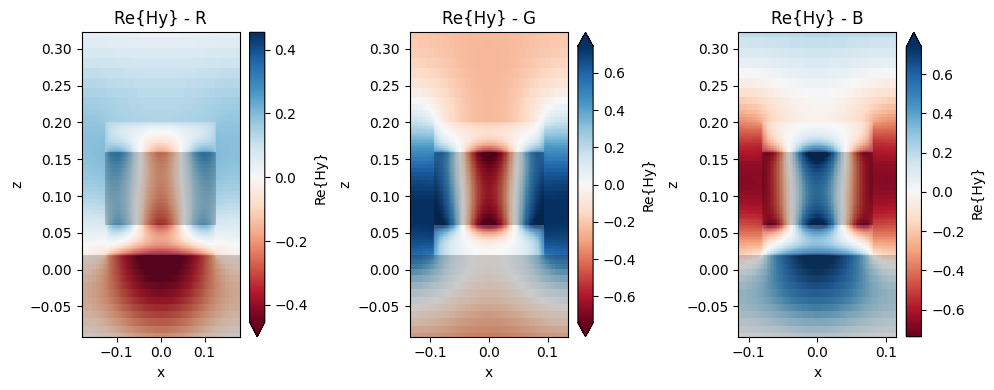

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)

sim_data[0].plot_field("field_xz", "Hy", y=0.0, f=freq_res[0], eps_alpha=0.2, ax=ax1)
ax1.set_title("Re{Hy} - R")
ax1.set_aspect("auto")

sim_data[1].plot_field("field_xz", "Hy", y=0.0, f=freq_res[1], eps_alpha=0.2, ax=ax2)
ax2.set_title("Re{Hy} - G")
ax2.set_aspect("auto")

sim_data[2].plot_field("field_xz", "Hy", y=0.0, f=freq_res[2], eps_alpha=0.2, ax=ax3)
ax3.set_title("Re{Hy} - B")
ax3.set_aspect("auto")

plt.show()